In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import scipy.stats as ss
import scipy
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode 

Чтобы считать данные использую API

In [18]:
def get_url(public_key): 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

In [22]:
assessments = pd.read_csv(get_url('https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'))
courses = pd.read_csv(get_url('https://disk.yandex.ru/d/jmJxR8yhwCXlaw')) 
studentAssessment = pd.read_csv(get_url('https://disk.yandex.ru/d/DYd4M5b_8RETsA')) 
studentRegistration = pd.read_csv(get_url('https://disk.yandex.ru/d/lqHnH8NOZ458iw'))

assessments.csv — этот файл содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).

courses.csv — файл содержит список предметов по семестрам.

studentAssessment.csv — этот файл содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

studentRegistration.csv — этот файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.

# 1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)

Информация об оценках и типе зачета содержится в разных файлах, следовательно, сначала их нужно объединить. 
Затем отобрать только успешно сданные зачеты ("Оценка ниже 40 неудачная/неуспешная сдача теста", следовательно, 40 и выше - удачная). 
В задании речь идет про экзамен, поэтому фильтрую по типу теста.
Затем нужно сгруппировать id студентов и посчитать, на какое количество курсов они записаны. 
В конце отобрать только тех студентов, которые прошли 1 курс.

In [24]:
score_assessments=assessments.merge(studentAssessment, how='inner', on='id_assessment') #объединяю фреймы

In [25]:
successfully=score_assessments.query('score>39') ## вывела только тех, кто получил оценку 40 и больше

In [26]:
successfully_exam=successfully.query('assessment_type=="Exam"') ## отбираю только тип - экзамен

In [27]:
successfully_group=successfully_exam.groupby('id_student', as_index=False).agg({'id_assessment':'count'}) ## сгруппировала по id студентов и посчитала количество курсов

In [28]:
successfully_group.query('id_assessment=="1"') ## отобрала только те id студентов, количество курсов которых равно 1

,id_student,id_assessment
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1
...,...,...
4092,2694886,1
4093,2694933,1
4094,2695608,1
4095,2697181,1


3802 студентов успешно сдали только один курс

##      2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. 

В этом задании речь снова идет об экзамене, поэтому фильтрую по нему.
Объединение таблиц с типом зачета и оценками было выше, 
поэтому использую эту же переменную. Также отбираю успешно сданные экзамены (от 40 score).
У меня нет информации о том, сколько один студент может сделать попыток сдать экзамен. Я делаю вывод, что одну.
Следовательно, у каждого студента будет по одной оценке.
Поэтому можно сгруппировать по id курса и посчитать количество оценок для всех попыток и для успешно сданных экзаменов.
"завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен"

In [29]:
Exam=score_assessments.query('assessment_type=="Exam"')  ## отобрала только экзамены

In [30]:
successfully_exam=Exam.query('score>39') ## отобрала успешно сданные экзамены

In [31]:
all=Exam.groupby('id_assessment').agg({'score':'count'}) ## группирую курсы и вычисляю количество всех попыток

In [32]:
success=successfully_exam.groupby('id_assessment').agg({'score':'count'}) ## группирую курсы и вычисляю количество успешно сданных экзаменов

In [33]:
success.score/all.score ## считаю завершаемость

id_assessment
24290    0.888889
24299    0.872432
25340    0.837209
25354    0.907025
25361    0.925573
25368    0.886316
Name: score, dtype: float64

Самый сложный экзамен в курсе (с низкой завершаемостью) - 25340

Самый простой экзамен в курсе (с высокой завершаемостью) - 25361

##      3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). 

Успешно сданные экзамены посчитала в предыдущих заданиях, беру ту же переменную. Проверяю количество пропущенных значений,
чтобы понимать, как будет считаться среднее. К счастью, в интересующих меня колонках их нет.
"date_submitted — дата сдачи теста студентом, измеряемая как количество дней с начала семестра".
Группирую по id курса и считаю среднее по date_submitted

In [34]:
successfully_exam.isna().sum() ## беру уже отсортированные успешно сданные экзамены и проверяю количество пропущенных значений

code_module             0
code_presentation       0
id_assessment           0
assessment_type         0
date                 2525
weight                  0
id_student              0
date_submitted          0
is_banked               0
score                   0
dtype: int64

In [35]:
successfully_exam.groupby('id_assessment').agg({'date_submitted': 'mean'}) ## группирую по курсам и считаю среднее

,date_submitted
id_assessment,
24290,231.581325
24299,244.404318
25340,230.164683
25354,239.509112
25361,234.936082
25368,242.804038


##  4. Выявить самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). 

В studentRegistration нет данных о предметах, поэтому объединяю с studentAssessment.
Далее группирую code_module (предметы) и считаю количество регистраций на них. Делаю это через count, так как даты логичнее 
считать через количество строк.
Затем вывожу топ-3, сортируя количество регистраций по убыванию.
Также считаю топ-3 предмета с самым большим оттоком ("date_unregistration — дата отмены регистрации студента с предмета")

In [36]:
registration=studentRegistration.merge(studentAssessment, how='inner', on='id_student') ## объединила таблицы, чтобы получить даты регистрации и номера курсов

In [37]:
registration_group=registration.groupby('code_module', as_index=False).agg({'date_registration':'count'}) ## сгруппировала и посчитала количество

In [38]:
registration_group.sort_values('date_registration', ascending=False).head(3) ## отсортировала по убыванию и вывела топ-3

,code_module,date_registration
5,FFF,60433
1,BBB,45166
3,DDD,37433


In [39]:
unregistration_group=registration.groupby('code_module', as_index=False).agg({'date_unregistration':'count'}) ## сгруппировала и посчитала количество

In [40]:
unregistration_group.sort_values('date_unregistration', ascending=False).head(3) ## отсортировала по убыванию и вывела топ-3

,code_module,date_unregistration
2,CCC,8729
3,DDD,5849
5,FFF,5722


##    5. Используя pandas, в период с начала 2013 по конец 2014 выявить семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.  

В наших данных и так только 2013 и 2014 год, поэтому нет смысла отбирать их отдельно.
В этом задании не нужно отбирать только экзамены, поэтому считать буду все типы теста.
Но по-преждему нужно фильтровать по score 40+, так как только такие курсы считаются сданными.
Группирую по семестрам и считаю среднее по количеству дней от начала семестра до сдачи теста.
Группирую по семестрам и использую count, так как нам нужно посчитать количество попыток, а не сумму.
Завершаемость считаю как кол-во успешных тестов / кол-во всех попыток сдать тест.
Далее сортирую по нужным колонкам, чтобы выявить средний срок сдачи курсов и завершаемость

In [41]:
pd.unique(registration.code_presentation)

array(['2013J', '2014J', '2014B', '2013B'], dtype=object)

In [42]:
high_score=registration.query('score>39') ## так как нужно вычеслить курсы, а не экзамены, выбираю тех, кто успешно завершил курс

In [43]:
group_assessment=high_score.groupby('code_presentation', as_index=False).agg({'date_registration':'mean'}) ##группирую по семестру, считаю среднее по сроку сдачи теста

In [44]:
completion_high=high_score.groupby('code_presentation', as_index=False).agg({'score':'count'}) ##группирую по семестру, считаю успешно сданные тесты

In [45]:
completion_all=registration.groupby('code_presentation', as_index=False).agg({'score':'count'})  ##группирую по семестру, считаю все попытки

In [46]:
group_assessment['completion']=completion_high.score/completion_all.score ## считаю завершенность

In [47]:
group_assessment.sort_values('date_registration') ## сортирую средний срок сдачи курсов: самый долгий семестр - 2013J

,code_presentation,date_registration,completion
1,2013J,-73.275130,0.961413
2,2014B,-68.928913,0.947563
3,2014J,-66.122577,0.945559
0,2013B,-58.199664,0.953417


In [48]:
group_assessment.sort_values('completion')  ## сортирую завершенность: самая низкая в семестре 2014J

,code_presentation,date_registration,completion
3,2014J,-66.122577,0.945559
2,2014B,-68.928913,0.947563
0,2013B,-58.199664,0.953417
1,2013J,-73.275130,0.961413


# 6. Сделать RFM-сегментацию студентов.

R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен.

В данном задании исследуем студентов, поэтому все группировки будут по id_student. Я уже фильтровала наши данные по типу теста 
по типу теста, беру эту же переменную. Вывожу интересующие нас метрики. Создаю dataframe с этими метриками.  
Использую функции для присвоения рангов. В RFM Score записываю полученные ранги.

In [49]:
from datetime import timedelta

In [50]:
Recency=Exam.groupby('id_student', as_index=False).agg({'date_submitted':'mean'}) ##выше уже была фильтрация данных только с типом "экзамен" - беру эту переменную. Считаю среднее время сдачи по каждому предмету

In [54]:
all_score=Exam.groupby('id_student', as_index=False).agg({'score':'count'}) ##сгруппировала по id студента, посчитала количество всех оценок

In [55]:
Frequency=high_score.score/all_score.score

In [56]:
high=Exam.query('score>39') ##отобрала только успешно сданные курсы

In [57]:
high_score=high.groupby('id_student', as_index=False).agg({'score':'count'})  ##сгруппировала по id студента, посчитала количество оценок успешно сданных курсов

In [58]:
Monetary=Exam.groupby('id_student', as_index=False).agg({'score':'mean'}) ##выше уже была фильтрация данных только с типом "экзамен" - беру эту переменную. Считаю среднее количество баллов

In [59]:
rfm=Recency

In [60]:
rfm['Monetary']=Monetary.score

In [61]:
rfm['Frequency']=Frequency

In [62]:
rfm=rfm.rename(columns={'date_submitted':'Recency'})

In [63]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 231.0, 0.4: 237.0, 0.6: 242.0, 0.8: 243.5},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 46.200000000000045, 0.4: 60.0, 0.6: 72.0, 0.8: 84.0}}

In [64]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5  

In [65]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [66]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,id_student,Recency,Monetary,Frequency,R,F,M,RFM Score
0,23698,243.0,80.0,1.0,2,1,4,214
1,24213,236.0,58.0,1.0,4,1,2,412
2,27116,243.0,96.0,1.0,2,1,5,215
3,28046,237.0,40.0,1.0,4,1,1,411
4,28787,243.0,44.0,1.0,2,1,1,211


Оценки RFM дают нам 5 в третьей степени = 125 сегментов. Это довольно много. 
Я выделю 9 сегментов, обединив ранги 1 и 2; 3 и 4; 5.

'losers' - сдают курсы медленно, получают плохие результаты

'at risk' - сдают курсы медленно, получают средние результаты

'perfectionists' - сдают курсы медленно, но получают хорошие результаты

'need attention' - сдают курсы со средней скоростью и получают плохие результаты

'medium' - сдают курсы со средней скоростью на средние результаты

'speed up a little' - сдают курсы со средней скоростью на хорошие результаты

'hurry' - сдают курсы быстро, но получают плохие результаты

'have potential'  - сдают курсы быстро, получают средние результаты

'excellent students' - сдают курсы быстро на хорошие результаты

In [67]:
segt_map = {
    r'[1-2][1-2]': 'losers',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'perfectionists',
    r'[3-4][1-2]': 'need attention',
    r'[3-4][3-4]': 'medium',
    r'[3-4]5': 'speed up a little',
    r'5[1-2]': 'hurry',
    r'[3-4][3-4]': 'have potential',
    r'5[4-5]': 'excellent students'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)

In [68]:
rfm

,id_student,Recency,Monetary,Frequency,R,F,M,RFM Score,Segment
0,23698,243.0,80.0,1.0,2,1,4,214,losers
1,24213,236.0,58.0,1.0,4,1,2,412,need attention
2,27116,243.0,96.0,1.0,2,1,5,215,losers
3,28046,237.0,40.0,1.0,4,1,1,411,need attention
4,28787,243.0,44.0,1.0,2,1,1,211,losers
...,...,...,...,...,...,...,...,...,...
4628,2694886,236.0,69.0,NaN,4,5,3,453,speed up a little
4629,2694933,230.0,73.0,NaN,5,5,4,554,excellent students
4630,2695608,237.0,73.0,NaN,4,5,4,454,speed up a little
4631,2697181,230.0,80.0,NaN,5,5,4,554,excellent students


Делаю визуализацию сегментов. Цветом выделяю сегменты студентов с хорошими результатами.

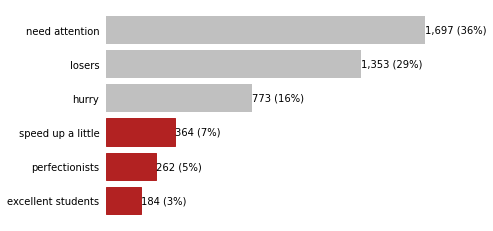

In [70]:
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['excellent students', 'perfectionists', 'speed up a little']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()